In [52]:
from binance.client import Client

client = Client()

klines = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1HOUR, "6 months ago UTC")

In [53]:
import pandas as pd
import pandas_ta as ta
import numpy as np

df = pd.DataFrame(klines, columns = ["open_time", "open", "high", "low", "close", "vol", "close_time", "quote_vol", \
                                    "trades", "taker_base_vol", "taker_quote_vol", "ignore"])

df = df[["open_time","open", "high", "low", "close"]]

df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")

df["open"] = df.open.astype(float)
df["high"] = df.high.astype(float)
df["low"] = df.low.astype(float)
df["close"] = df.close.astype(float)

## take the rolling atr so the yaxis doesn't shake too much
df["atr"] = ta.atr(high=df.high, low=df.low, close=df.close)
df["atr"] = df.atr.rolling(window=30).mean()

df.set_index("open_time", inplace=True)
df

,open,high,low,close,atr
open_time,,,,,
2022-09-21 20:00:00,1323.47,1327.35,1308.16,1315.02,NaN
2022-09-21 21:00:00,1315.01,1315.02,1241.36,1253.11,NaN
2022-09-21 22:00:00,1253.12,1255.50,1220.00,1243.89,NaN
2022-09-21 23:00:00,1243.89,1255.36,1239.90,1245.78,NaN
2022-09-22 00:00:00,1245.79,1252.04,1237.32,1242.88,NaN
...,...,...,...,...,...
2023-03-21 15:00:00,1805.49,1819.14,1802.96,1812.55,19.446419
2023-03-21 16:00:00,1812.54,1825.98,1806.49,1811.80,19.431556
2023-03-21 17:00:00,1811.80,1815.47,1787.32,1790.17,19.443612


In [54]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from IPython import display
from IPython.display import HTML
pd.set_option("mode.chained_assignment", None)

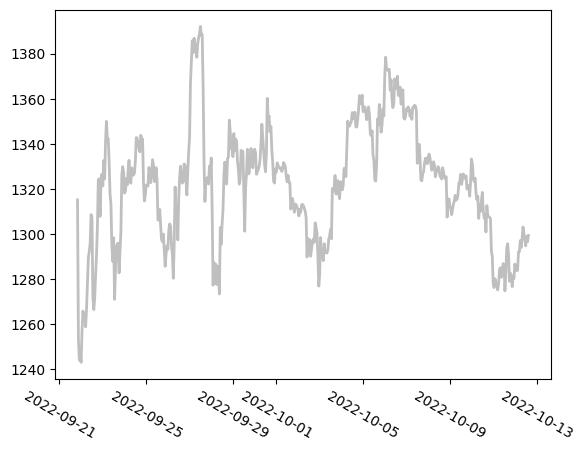

In [55]:
df2 = df.iloc[0:500]

fig, ax = plt.subplots()

plt.xticks(rotation=-30)

price, = ax.plot(df2.index, df2.close, c="grey", lw=2, alpha=0.5, zorder=5)

plt.show()

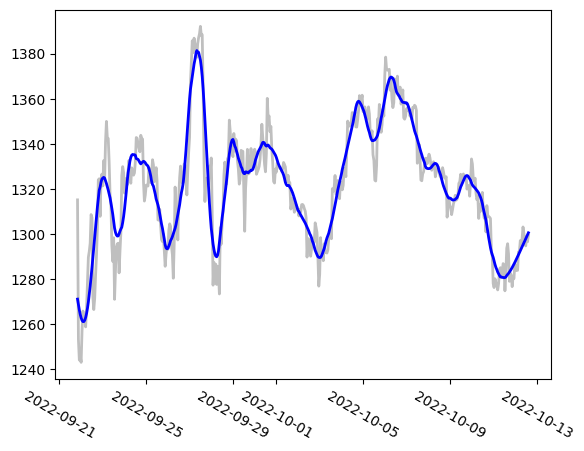

In [56]:
df2 = df.iloc[0:500]

df2["close_smooth"] = savgol_filter(df2.close, 49, 5)

fig, ax = plt.subplots()
plt.xticks(rotation=-30)
price, = ax.plot(df2.index, df2.close, c="grey", lw=2, alpha=0.5, zorder=5)
price_smooth, = ax.plot(df2.index, df2.close_smooth, c="b", lw=2, zorder=5) 

plt.show()

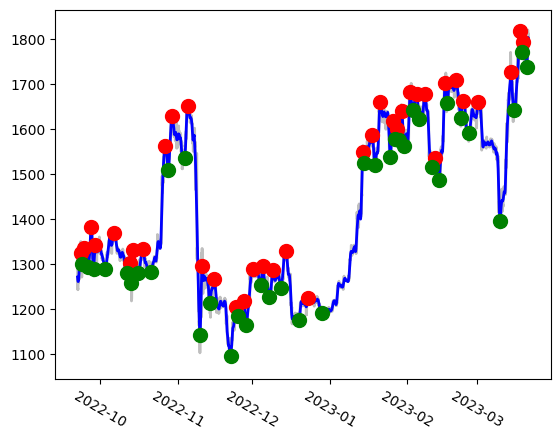

In [57]:
# df2 = df.iloc[0:500]
df2 = df

df2["close_smooth"] = savgol_filter(df2.close, 49, 5)

fig, ax = plt.subplots()
plt.xticks(rotation=-30)
price, = ax.plot(df2.index, df2.close, c="grey", lw=2, alpha=0.5, zorder=5)
price_smooth, = ax.plot(df2.index, df2.close_smooth, c="b", lw=2, zorder=5) 

atr = df2.atr.iloc[-1]

peaks_idx, _ = find_peaks(df2.close_smooth, distance=15, width=3, prominence=atr)
troughs_idx, _ = find_peaks(-1*df2.close_smooth, distance=15, width=3, prominence=atr)

peaks, = ax.plot(df2.index[peaks_idx], df2.close_smooth.iloc[peaks_idx], \
                c="r", linestyle="None", markersize=10.0, marker="o", zorder=10)

thoughs, = ax.plot(df2.index[troughs_idx], df2.close_smooth.iloc[troughs_idx], \
                c="g", linestyle="None", markersize=10.0, marker="o", zorder=10)

plt.show()

In [58]:
peaks_idx, _ = find_peaks(df2.close_smooth, distance=15, width=3, prominence=atr)
troughs_idx, _ = find_peaks(-1*df2.close_smooth, distance=15, width=3, prominence=atr)

print(peaks_idx)
print(troughs_idx)


[  29   61  132  172  347  502  539  627  839  911 1060 1199 1313 1527
 1599 1688 1785 1881 2009 2222 2750 2840 2916 3036 3076 3124 3206 3266
 3346 3443 3542 3646 3711 3861 4177 4262 4294]
[  44   99  154  268  472  519  582  705  874 1032 1179 1273 1474 1550
 1626 1763 1849 1956 2132 2350 2762 2865 3013 3059 3092 3147 3227 3293
 3416 3481 3563 3689 3774 4069 4203 4279 4326]


In [60]:
# Create a new column in the DataFrame called "position"
df2['position'] = 0

# Set position values based on long and short signals
# df2['position'] = np.zeros(len(df))
df2['position'].iloc[peaks_idx] = 1
df2['position'].iloc[troughs_idx] = -1

# Adjust the position column to hold the most recent position until there is a signal to go in the other direction
prev_pos = 0
for i in range(len(df)):
    if df['position'][i] != 0:
        prev_pos = df['position'][i]
    else:
        df['position'][i] = prev_pos


df2[27:47]

,open,high,low,close,atr,close_smooth,position
open_time,,,,,,,
2022-09-22 23:00:00,1323.54,1350.08,1322.40,1326.46,NaN,1324.281292,0
2022-09-23 00:00:00,1326.47,1339.99,1320.76,1321.21,NaN,1324.724359,0
2022-09-23 01:00:00,1321.21,1334.00,1314.42,1332.44,NaN,1325.018574,1
2022-09-23 02:00:00,1332.44,1333.99,1320.84,1324.31,NaN,1324.694710,1
2022-09-23 03:00:00,1324.32,1345.40,1324.31,1340.77,NaN,1323.501701,1
2022-09-23 04:00:00,1340.77,1360.00,1333.01,1349.86,NaN,1322.284593,1
2022-09-23 05:00:00,1349.86,1355.71,1342.42,1342.43,NaN,1320.883428,1
2022-09-23 06:00:00,1342.43,1349.34,1341.83,1342.29,NaN,1319.350279,1
2022-09-23 07:00:00,1342.30,1343.39,1328.58,1331.82,NaN,1317.663712,1


In [66]:
import backtesting

df2 = df2.rename(columns={"open": "Open", "close": "Close", "low": "Low", "high": "High"})

class MyStrategy(backtesting.Strategy):
    
    stop_loss_percent = 15
    last_purchase_price = 0
    long_hold = 0
    short_hold = 0
    i = 0
    
    def init(self):
        super().init()
        
    def next(self):
        super().init()

        self.i += 1

        long_entry_signals = 0
        long_exit_signals = 0
        short_entry_signals = 0
        short_exit_signals = 0
        
        
    
        # If position is 1, go long
        if self.position == 1:
            long_entry_signals += 1
            short_exit_signals += 1
        # If position is -1, go short
        if self.position == -1:
            long_exit_signals += 1
            short_entry_signals += 1
      
        #  Stop loss
        price = self.data.df['Close'][-1]
        if price <= self.last_purchase_price * (1 - self.stop_loss_percent/100):
            long_exit_signals += 1

        if price >= self.last_purchase_price * (1 + self.stop_loss_percent/100):
            short_exit_signals += 1

        #  LONG
        #--------------------------------------------------
        if self.long_hold == 0 and long_entry_signals >= 1:
            #  Buy
            self.long_hold = 1
            self.position.close()
            self.buy()
            self.last_purchase_price = price

        elif self.long_hold == 1 and long_exit_signals >= 1:
            # Close any existing long trades, and sell the asset
            self.long_hold = 0
            self.position.close()
            self.last_purchase_price = 0

        #  SHORT
        #--------------------------------------------------
        if self.short_hold == 0 and short_entry_signals >= 1:
            #  Sell
            self.short_hold = 1
            self.position.close()
            self.sell()
            self.last_purchase_price = price

        elif self.short_hold == 1 and short_exit_signals >= 1:
            # Close any existing long trades, and sell the asset
            self.short_hold = 0
            self.position.close()
            self.last_purchase_price = 0
            
# Backtest the strategy
bt = backtesting.Backtest(df2, MyStrategy, cash=10000, commission=0.002)
results = bt.run()

# Print the results
print(results)

Start                     2022-09-21 20:00:00
End                       2023-03-21 19:00:00
Duration                    180 days 23:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]               36.140895
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

In [65]:
df2

,Open,high,low,close,atr,close_smooth,position
open_time,,,,,,,
2022-09-21 20:00:00,1323.47,1327.35,1308.16,1315.02,NaN,1270.951647,0
2022-09-21 21:00:00,1315.01,1315.02,1241.36,1253.11,NaN,1268.449221,0
2022-09-21 22:00:00,1253.12,1255.50,1220.00,1243.89,NaN,1266.151909,0
2022-09-21 23:00:00,1243.89,1255.36,1239.90,1245.78,NaN,1264.174043,0
2022-09-22 00:00:00,1245.79,1252.04,1237.32,1242.88,NaN,1262.607799,0
...,...,...,...,...,...,...,...
2023-03-21 15:00:00,1805.49,1819.14,1802.96,1812.55,19.446419,1800.739229,-1
2023-03-21 16:00:00,1812.54,1825.98,1806.49,1811.80,19.431556,1803.004354,-1
2023-03-21 17:00:00,1811.80,1815.47,1787.32,1790.17,19.443612,1802.649472,-1
